In [5]:
# Make sure all necessary imports are included
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random


In [6]:
# implementing a simple policy network for tic tac toe that outputs a probability distribution over all moves

class SimplePolicyNetwork(nn.Module):
    def __init__(self, board_size, num_moves):
        """
        Initializes the Policy Network.
        :param board_size: Tuple of the board dimensions, e.g., (19, 19) for Go.
        :param num_moves: Total number of possible moves in the game.
        """
        super(SimplePolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128 * board_size[0] * board_size[1], num_moves)

    def forward(self, x):
        """
        Forward pass of the network.
        :param x: Input tensor, the game state.
        :return: Probability distribution over all possible moves.
        """
        # Apply two convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Output layer with a softmax to get probabilities
        x = self.fc(x)
        return F.softmax(x, dim=1)

# Example usage
board_size = (3, 3)  # For Tic Tac Toe
num_moves = board_size[0] * board_size[1]  # Assuming each cell is a possible move
model = SimplePolicyNetwork(board_size, num_moves)

# Example input: a single game state, with 1 channel, and 19x19 board size
# The input should be a 4D tensor: [batch_size, channels, height, width]
# Here, batch_size = 1, channels = 1 (just the board, could be more for different game states)
game_state = torch.randn(1, 1, board_size[0], board_size[1])
# Get the probability distribution over moves
probabilities = model(game_state)

print(probabilities)  # Each element corresponds to the probability of a move being the best next move


tensor([[0.1277, 0.1175, 0.1327, 0.0961, 0.1070, 0.1032, 0.0981, 0.1122, 0.1054]],
       grad_fn=<SoftmaxBackward0>)


In [7]:
# Solving tic-tac-toe using tree search
# This is a simple implementation of the minimax algorithm

# The game is represented as a 3x3 matrix
# 0 represents an empty cell
# 1 represents a cell with a cross
# 2 represents a cell with a circle

class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.turn = 1
        self.winner = 0

    def is_full(self):
        return np.all(self.board)

    def is_winner(self, player):
        for i in range(3):
            if np.all(self.board[i] == player) or np.all(self.board[:, i] == player):
                return True
        if np.all(self.board.diagonal() == player) or np.all(np.fliplr(self.board).diagonal() == player):
            return True
        return False

    def is_game_over(self):
        # Check if any player has won
        for player in [1, 2]:
            if self.is_winner(player):
                self.winner = player
                return True
        # If no winner and the board is full, it's a draw
        if self.is_full():
            self.winner = 0  # Indicate a draw
            return True
        # Game is not over
        return False


    def get_valid_moves(self):
        return np.argwhere(self.board == 0)
    
    def get_valid_moves_indices(self):
        return np.flatnonzero(self.board == 0)
    

    def make_move(self, move):
        self.board[tuple(move)] = self.turn
        self.turn = 3 - self.turn

    def make_move_from_index(self, index):
        move = np.unravel_index(index, (3, 3))
        self.make_move(move)

    def undo_move(self, move):
        self.board[tuple(move)] = 0
        self.turn = 3 - self.turn

    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)

    def __str__(self):
        return str(self.board)


In [8]:
# game = TicTacToe()
# game.make_move((1,1))
# print(game)

# game.make_move((2,1))
# print(game)

# game.make_move((0,1))
# print(game)

In [9]:
def convert_board_to_input(board):
    """
    Convert the game board to a tensor suitable for the policy network.
    The input is a 4D tensor: [batch_size, channels, height, width].
    """
    # Convert the board to a tensor with shape (1, 1, 3, 3)
    # 1 channel, the board's state is represented in a 3x3 grid
    board_tensor = torch.tensor(board, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    return board_tensor

def select_move(probabilities, valid_moves_indices):
    """
    Select the move with the highest probability that is also a valid move.
    """
    # Zero out the probabilities of moves that are not valid
    prob_masked = probabilities.clone().detach()
    prob_masked[0, np.setdiff1d(np.arange(num_moves), valid_moves_indices)] = 0
    # Select the move with the highest probability
    move_index = torch.argmax(prob_masked).item()
    return move_index

# Initialize the TicTacToe game
game = TicTacToe()

# Initialize the policy network
model = SimplePolicyNetwork(board_size, num_moves)

# Play until the game is over
while not game.is_game_over():
    # Convert the current game state to a tensor input for the network
    current_state_tensor = convert_board_to_input(game.board)
    # Get the probability distribution over moves from the policy network
    probabilities = model(current_state_tensor)
    # Get valid move indices
    valid_moves_indices = game.get_valid_moves_indices()
    # Select the move with the highest probability among valid moves
    selected_move_index = select_move(probabilities, valid_moves_indices)
    # Make the move
    game.make_move_from_index(selected_move_index)
    # Print the board state
    print(game)
    print("------")

# Check the result
if game.winner:
    print(f"Player {game.winner} wins!")
else:
    print("It's a draw!")

[[0 0 0]
 [0 0 0]
 [1 0 0]]
------
[[0 0 2]
 [0 0 0]
 [1 0 0]]
------
[[0 0 2]
 [1 0 0]
 [1 0 0]]
------
[[0 2 2]
 [1 0 0]
 [1 0 0]]
------
[[1 2 2]
 [1 0 0]
 [1 0 0]]
------
Player 1 wins!


In [13]:
import matplotlib.pyplot as plt

import random

def play_game_with_random(policy_model, game, random_agent, start_first=True):
    game.reset()
    # Randomly choose which agent starts
    game.turn = random.choice([1, 2])
    while not game.is_game_over():
        if game.turn == 1:  # Policy network's turn
            current_state_tensor = convert_board_to_input(game.board)
            probabilities = policy_model(current_state_tensor)
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = select_move(probabilities, valid_moves_indices)
            game.make_move_from_index(selected_move_index)
        else:  # Random agent's turn
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = random_agent.select_move(valid_moves_indices)
            game.make_move_from_index(selected_move_index)
    return game.winner

wins = {1: 0, 2: 0, 0: 0}  # 1: Policy Network, 2: Random Agent, 0: Draw
num_simulations = 5000

for _ in range(num_simulations):
    winner = play_game_with_random(model, game, random_agent, start_first)
    wins[winner] += 1
    game.reset()  # Reset the game to its initial state after each simulation


# Plotting win rates
labels = ['Policy Network Wins', 'Random Agent Wins', 'Draws']
values = [wins[1], wins[2], wins[0]]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.title('Win Rates After 100 Simulations')
plt.ylabel('Number of Games')
plt.show()


NameError: name 'random_agent' is not defined

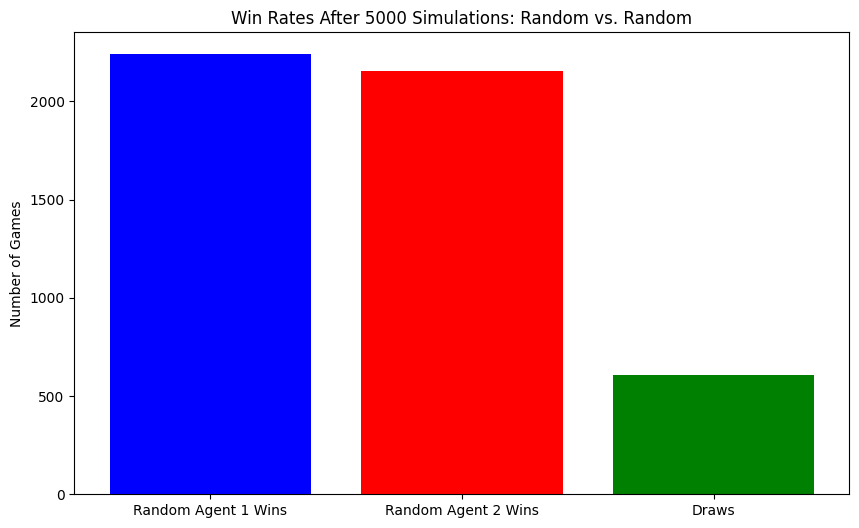

In [14]:
# Defining a function to simulate a game between two random agents
def play_game_random_vs_random(game, agent1, agent2):
    game.reset()
    # Randomly choose which agent starts
    game.turn = random.choice([1, 2])
    while not game.is_game_over():
        if game.turn == 1:  # Random agent 1's turn
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = agent1.select_move(valid_moves_indices)
            game.make_move_from_index(selected_move_index)
        else:  # Random agent 2's turn
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = agent2.select_move(valid_moves_indices)
            game.make_move_from_index(selected_move_index)
    return game.winner

class RandomAgent:
    def __init__(self):
        pass

    def select_move(self, valid_moves_indices):
        """
        Selects a move randomly from the list of valid move indices.
        :param valid_moves_indices: A list of indices representing valid moves.
        :return: An index representing the selected move.
        """
        return random.choice(valid_moves_indices)

# Initializing the game and two random agents
game = TicTacToe()
random_agent1 = RandomAgent()
random_agent2 = RandomAgent()

gameHistory = []

# Simulating games
wins_random_vs_random = {1: 0, 2: 0, 0: 0}  # 1: Random Agent 1, 2: Random Agent 2, 0: Draw
num_simulations_random_vs_random = 5000

for _ in range(num_simulations_random_vs_random):
    winner = play_game_random_vs_random(game, random_agent1, random_agent2)
    wins_random_vs_random[winner] += 1
    # Store a copy of the board's state and the winner at this point
    final_state = (np.copy(game.board), game.winner)
    gameHistory.append(final_state)
    game.reset()  # Reset the game to its initial state after each simulation

# Plotting win rates for games between two random agents
labels_random_vs_random = ['Random Agent 1 Wins', 'Random Agent 2 Wins', 'Draws']
values_random_vs_random = [wins_random_vs_random[1], wins_random_vs_random[2], wins_random_vs_random[0]]

plt.figure(figsize=(10, 6))
plt.bar(labels_random_vs_random, values_random_vs_random, color=['blue', 'red', 'green'])
plt.title('Win Rates After 5000 Simulations: Random vs. Random')
plt.ylabel('Number of Games')
plt.show()



In [21]:
import torch.optim as optim
from tqdm.notebook import tqdm


In [22]:
def compute_returns(rewards, gamma=1.0):
    """
    Compute returns for each time step, given the rewards
    and a discount factor gamma.
    """
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

# Initialize environment, policy network, and optimizer
game = TicTacToe()
policy_network = SimplePolicyNetwork(board_size=(3, 3), num_moves=9)
optimizer = optim.Adam(policy_network.parameters(), lr=0.001)

num_episodes = 10000


def get_reward(game):
    """
    Defines the reward for the policy network based on the game's outcome.
    Assume the policy network always plays as player 1.
    """
    if game.is_winner(1):  # Policy network wins
        return 1
    elif game.is_winner(2):  # Policy network loses
        return -1
    return 0  # No reward for intermediate moves


win_record = []
policy_losses = []  # Store policy losses for plotting
episode_rewards = []  # Average reward per episode

# Training loop
for episode in tqdm(range(num_episodes), desc="Processing Episodes"):
    saved_log_probs = []
    rewards = []
    game.reset()
    while not game.is_game_over():
        if game.turn == 1:  # Policy network's turn
            state = convert_board_to_input(game.board)
            probs = policy_network(state)
            action = torch.multinomial(probs, 1).item()  # Sample action
            saved_log_probs.append(torch.log(probs.squeeze(0)[action]))
            game.make_move_from_index(action)
        else:  # Random agent's turn
            valid_moves = game.get_valid_moves_indices()
            action = np.random.choice(valid_moves)
            game.make_move_from_index(action)
        reward = get_reward(game)  # Define a suitable reward function
        rewards.append(reward)
    
    # Compute returns
    returns = compute_returns(rewards)
    returns = torch.tensor(returns)

    # Determine the outcome of the episode
    win_record.append(game.winner)
    episode_rewards.append(np.mean(rewards))
    
    # Collect individual loss tensors in a list
    policy_loss_terms = []
    for log_prob, R in zip(saved_log_probs, returns):
        loss = -log_prob * R
        policy_loss_terms.append(loss.unsqueeze(0))

    # Concatenate and sum to compute the total policy loss for the episode
    total_policy_loss = torch.cat(policy_loss_terms).sum()
    policy_losses.append(total_policy_loss.item())  # Recording scalar loss

    # Use total_policy_loss for gradient computation
    optimizer.zero_grad()
    total_policy_loss.backward()
    optimizer.step()



Processing Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

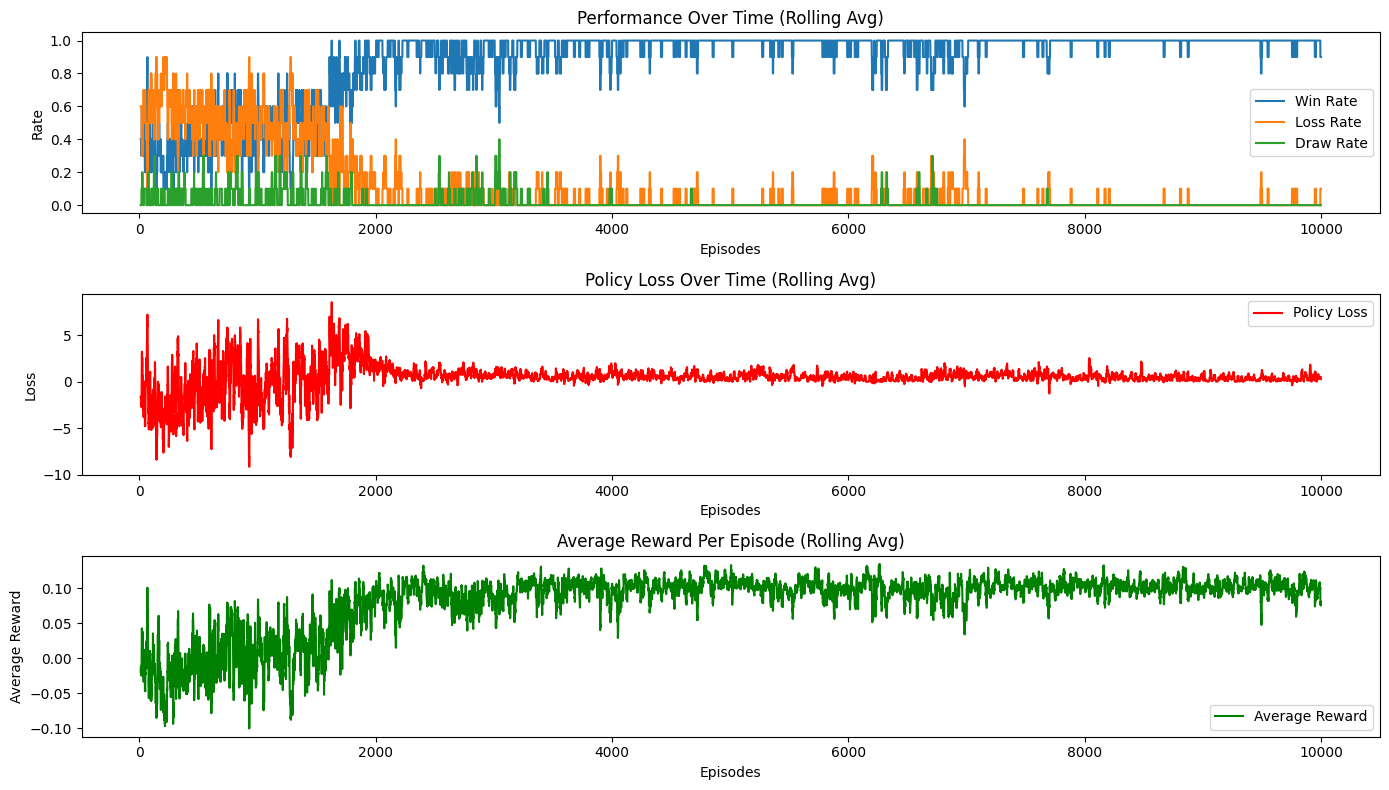

In [23]:

import numpy as np
import matplotlib.pyplot as plt

# Function to calculate rolling average using np.convolve
def calculate_rolling_average(data, window_size=10):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, 'valid')

# Convert win_record to binary for win, loss, and draw
wins_binary = (np.array(win_record) == 1).astype(float)
losses_binary = (np.array(win_record) == 2).astype(float)
draws_binary = (np.array(win_record) == 0).astype(float)

# Calculate rolling averages
rolling_avg_win_rate = calculate_rolling_average(wins_binary)
rolling_avg_loss_rate = calculate_rolling_average(losses_binary)
rolling_avg_draw_rate = calculate_rolling_average(draws_binary)
rolling_avg_policy_losses = calculate_rolling_average(policy_losses)
rolling_avg_episode_rewards = calculate_rolling_average(episode_rewards)

# Plotting
window_size = 10  # Adjust window_size if needed

plt.figure(figsize=(14, 8))

# Win, Loss, Draw Rates
plt.subplot(3, 1, 1)
episodes_adjusted = np.arange(window_size, len(win_record) + 1)
plt.plot(episodes_adjusted, rolling_avg_win_rate, label='Win Rate')
plt.plot(episodes_adjusted, rolling_avg_loss_rate, label='Loss Rate')
plt.plot(episodes_adjusted, rolling_avg_draw_rate, label='Draw Rate')
plt.xlabel('Episodes')
plt.ylabel('Rate')
plt.title('Performance Over Time (Rolling Avg)')
plt.legend()

# Policy Loss
plt.subplot(3, 1, 2)
plt.plot(episodes_adjusted, rolling_avg_policy_losses, label='Policy Loss', color='red')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Policy Loss Over Time (Rolling Avg)')
plt.legend()

# Average Rewards
plt.subplot(3, 1, 3)
plt.plot(episodes_adjusted, rolling_avg_episode_rewards, label='Average Reward', color='green')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward Per Episode (Rolling Avg)')
plt.legend()

plt.tight_layout()
plt.show()


In [38]:
# self play

def compute_returns(rewards, gamma=1.0):
    """
    Compute returns for each time step, given the rewards
    and a discount factor gamma.
    """
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

# Initialize environment, policy network, and optimizer
game = TicTacToe()
policy_network = SimplePolicyNetwork(board_size=(3, 3), num_moves=9)
optimizer = optim.Adam(policy_network.parameters(), lr=0.001)

num_episodes = 10000


def get_reward(game):
    """
    Defines the reward for the policy network based on the game's outcome.
    Assume the policy network always plays as player 1.
    """
    if game.is_winner(1):  # Policy network wins
        return 1
    elif game.is_winner(2):  # Policy network loses
        return -1
    return 0  # No reward for intermediate moves


win_record = []
policy_losses = []  # Store policy losses for plotting
episode_rewards = []  # Average reward per episode

# Training loop
for episode in range(num_episodes):
    saved_log_probs = []
    rewards = []
    game.reset()
    while not game.is_game_over():
        if game.turn == 1:  # Policy network's turn
            state = convert_board_to_input(game.board)
            probs = policy_network(state)
            action = torch.multinomial(probs, 1).item()  # Sample action
            saved_log_probs.append(torch.log(probs.squeeze(0)[action]))
            game.make_move_from_index(action)
        else:  # Random agent's turn
            valid_moves = game.get_valid_moves_indices()
            action = np.random.choice(valid_moves)
            game.make_move_from_index(action)
        reward = get_reward(game)  # Define a suitable reward function
        rewards.append(reward)
    
    # Compute returns
    returns = compute_returns(rewards)
    returns = torch.tensor(returns)

    # Determine the outcome of the episode
    win_record.append(game.winner)
    episode_rewards.append(np.mean(rewards))
    
    # Collect individual loss tensors in a list
    policy_loss_terms = []
    for log_prob, R in zip(saved_log_probs, returns):
        loss = -log_prob * R
        policy_loss_terms.append(loss.unsqueeze(0))

    # Concatenate and sum to compute the total policy loss for the episode
    total_policy_loss = torch.cat(policy_loss_terms).sum()
    policy_losses.append(total_policy_loss.item())  # Recording scalar loss

    # Use total_policy_loss for gradient computation
    optimizer.zero_grad()
    total_policy_loss.backward()
    optimizer.step()



In [4]:
import streamlit as st
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

# Your SimplePolicyNetwork class code goes here
# Your TicTacToe class code goes here

# Initialize the TicTacToe game and the policy network
board_size = (3, 3)  # For Tic Tac Toe
num_moves = board_size[0] * board_size[1]  # Assuming each cell is a possible move
model = SimplePolicyNetwork(board_size, num_moves)

game = TicTacToe()

def convert_board_to_input(board):
    """
    Convert the game board to a tensor suitable for the policy network.
    The input is a 4D tensor: [batch_size, channels, height, width].
    """
    board_tensor = torch.tensor(board, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    return board_tensor

def select_move(probabilities, valid_moves_indices):
    """
    Select the move with the highest probability that is also a valid move.
    """
    prob_masked = probabilities.clone().detach()
    prob_masked[0, np.setdiff1d(np.arange(num_moves), valid_moves_indices)] = 0
    move_index = torch.argmax(prob_masked).item()
    return move_index

def make_ai_move():
    current_state_tensor = convert_board_to_input(game.board)
    probabilities = model(current_state_tensor)
    valid_moves_indices = game.get_valid_moves_indices()
    selected_move_index = select_move(probabilities, valid_moves_indices)
    game.make_move_from_index(selected_move_index)

# Streamlit UI
st.title('Tic-Tac-Toe with AI')

# Display the board and handle moves
for row in range(3):
    cols = st.columns(3)
    for col, _ in enumerate(cols):
        cell_value = game.board[row, col]
        label = ' ' if cell_value == 0 else ('X' if cell_value == 1 else 'O')
        if cols[col].button(label, key=f'cell-{row}-{col}'):
            if game.board[row, col] == 0:  # If cell is empty
                game.make_move((row, col))
                if not game.is_game_over():
                    make_ai_move()  # AI makes its move

# Display game status
if game.is_game_over():
    if game.winner == 0:
        st.write("It's a draw!")
    else:
        st.write(f"Player {game.winner} wins!")
else:
    st.write("Your turn!" if game.turn == 1 else "AI's turn!")

if st.button('Reset Game'):
    game.reset()


NameError: name 'SimplePolicyNetwork' is not defined

In [40]:
# Make sure all necessary imports are included
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random


In [41]:
# implementing a simple policy network for tic tac toe that outputs a probability distribution over all moves

class SimplePolicyNetwork(nn.Module):
    def __init__(self, board_size, num_moves):
        """
        Initializes the Policy Network.
        :param board_size: Tuple of the board dimensions, e.g., (19, 19) for Go.
        :param num_moves: Total number of possible moves in the game.
        """
        super(SimplePolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128 * board_size[0] * board_size[1], num_moves)

    def forward(self, x):
        """
        Forward pass of the network.
        :param x: Input tensor, the game state.
        :return: Probability distribution over all possible moves.
        """
        # Apply two convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Output layer with a softmax to get probabilities
        x = self.fc(x)
        return F.softmax(x, dim=1)

# Example usage
board_size = (3, 3)  # For Tic Tac Toe
num_moves = board_size[0] * board_size[1]  # Assuming each cell is a possible move
model = SimplePolicyNetwork(board_size, num_moves)

# Example input: a single game state, with 1 channel, and 19x19 board size
# The input should be a 4D tensor: [batch_size, channels, height, width]
# Here, batch_size = 1, channels = 1 (just the board, could be more for different game states)
game_state = torch.randn(1, 1, board_size[0], board_size[1])
# Get the probability distribution over moves
probabilities = model(game_state)

print(probabilities)  # Each element corresponds to the probability of a move being the best next move


tensor([[0.1102, 0.1061, 0.1215, 0.1184, 0.1128, 0.1087, 0.1180, 0.0982, 0.1062]],
       grad_fn=<SoftmaxBackward0>)


In [2]:
# Solving tic-tac-toe using tree search
# This is a simple implementation of the minimax algorithm

# The game is represented as a 3x3 matrix
# 0 represents an empty cell
# 1 represents a cell with a cross
# 2 represents a cell with a circle

class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.turn = 1
        self.winner = 0

    def is_full(self):
        return np.all(self.board)

    def is_winner(self, player):
        for i in range(3):
            if np.all(self.board[i] == player) or np.all(self.board[:, i] == player):
                return True
        if np.all(self.board.diagonal() == player) or np.all(np.fliplr(self.board).diagonal() == player):
            return True
        return False

    def is_game_over(self):
        # Check if any player has won
        for player in [1, 2]:
            if self.is_winner(player):
                self.winner = player
                return True
        # If no winner and the board is full, it's a draw
        if self.is_full():
            self.winner = 0  # Indicate a draw
            return True
        # Game is not over
        return False


    def get_valid_moves(self):
        return np.argwhere(self.board == 0)
    
    def get_valid_moves_indices(self):
        return np.flatnonzero(self.board == 0)
    

    def make_move(self, move):
        self.board[tuple(move)] = self.turn
        self.turn = 3 - self.turn

    def make_move_from_index(self, index):
        move = np.unravel_index(index, (3, 3))
        self.make_move(move)

    def undo_move(self, move):
        self.board[tuple(move)] = 0
        self.turn = 3 - self.turn

    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)

    def __str__(self):
        return str(self.board)


In [43]:
# game = TicTacToe()
# game.make_move((1,1))
# print(game)

# game.make_move((2,1))
# print(game)

# game.make_move((0,1))
# print(game)

In [44]:
def convert_board_to_input(board):
    """
    Convert the game board to a tensor suitable for the policy network.
    The input is a 4D tensor: [batch_size, channels, height, width].
    """
    # Convert the board to a tensor with shape (1, 1, 3, 3)
    # 1 channel, the board's state is represented in a 3x3 grid
    board_tensor = torch.tensor(board, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    return board_tensor

def select_move(probabilities, valid_moves_indices):
    """
    Select the move with the highest probability that is also a valid move.
    """
    # Zero out the probabilities of moves that are not valid
    prob_masked = probabilities.clone().detach()
    prob_masked[0, np.setdiff1d(np.arange(num_moves), valid_moves_indices)] = 0
    # Select the move with the highest probability
    move_index = torch.argmax(prob_masked).item()
    return move_index

# Initialize the TicTacToe game
game = TicTacToe()

# Initialize the policy network
model = SimplePolicyNetwork(board_size, num_moves)

# Play until the game is over
while not game.is_game_over():
    # Convert the current game state to a tensor input for the network
    current_state_tensor = convert_board_to_input(game.board)
    # Get the probability distribution over moves from the policy network
    probabilities = model(current_state_tensor)
    # Get valid move indices
    valid_moves_indices = game.get_valid_moves_indices()
    # Select the move with the highest probability among valid moves
    selected_move_index = select_move(probabilities, valid_moves_indices)
    # Make the move
    game.make_move_from_index(selected_move_index)
    # Print the board state
    print(game)
    print("------")

# Check the result
if game.winner:
    print(f"Player {game.winner} wins!")
else:
    print("It's a draw!")

[[0 0 0]
 [0 0 0]
 [0 0 1]]
------
[[0 0 0]
 [0 2 0]
 [0 0 1]]
------
[[0 0 0]
 [0 2 0]
 [0 1 1]]
------
[[0 0 0]
 [2 2 0]
 [0 1 1]]
------
[[0 0 1]
 [2 2 0]
 [0 1 1]]
------
[[0 0 1]
 [2 2 2]
 [0 1 1]]
------
Player 2 wins!


In [3]:
import matplotlib.pyplot as plt

import random

def play_game_with_random(policy_model, game, random_agent, start_first=True):
    game.reset()
    # Randomly choose which agent starts
    game.turn = random.choice([1, 2])
    while not game.is_game_over():
        if game.turn == 1:  # Policy network's turn
            current_state_tensor = convert_board_to_input(game.board)
            probabilities = policy_model(current_state_tensor)
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = select_move(probabilities, valid_moves_indices)
            game.make_move_from_index(selected_move_index)
        else:  # Random agent's turn
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = random_agent.select_move(valid_moves_indices)
            game.make_move_from_index(selected_move_index)
    return game.winner

wins = {1: 0, 2: 0, 0: 0}  # 1: Policy Network, 2: Random Agent, 0: Draw
num_simulations = 5000

for _ in range(num_simulations):
    winner = play_game_with_random(model, game, random_agent, start_first)
    wins[winner] += 1
    game.reset()  # Reset the game to its initial state after each simulation


# Plotting win rates
labels = ['Policy Network Wins', 'Random Agent Wins', 'Draws']
values = [wins[1], wins[2], wins[0]]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.title('Win Rates After 100 Simulations')
plt.ylabel('Number of Games')
plt.show()


NameError: name 'model' is not defined

In [1]:
# Defining a function to simulate a game between two random agents
def play_game_random_vs_random(game, agent1, agent2):
    game.reset()
    # Randomly choose which agent starts
    game.turn = random.choice([1, 2])
    while not game.is_game_over():
        if game.turn == 1:  # Random agent 1's turn
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = agent1.select_move(valid_moves_indices)
            game.make_move_from_index(selected_move_index)
        else:  # Random agent 2's turn
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = agent2.select_move(valid_moves_indices)
            game.make_move_from_index(selected_move_index)
    return game.winner

# Initializing the game and two random agents
game = TicTacToe()
random_agent1 = RandomAgent()
random_agent2 = RandomAgent()

gameHistory = []

# Simulating games
wins_random_vs_random = {1: 0, 2: 0, 0: 0}  # 1: Random Agent 1, 2: Random Agent 2, 0: Draw
num_simulations_random_vs_random = 5000

for _ in range(num_simulations_random_vs_random):
    winner = play_game_random_vs_random(game, random_agent1, random_agent2)
    wins_random_vs_random[winner] += 1
    # Store a copy of the board's state and the winner at this point
    final_state = (np.copy(game.board), game.winner)
    gameHistory.append(final_state)
    game.reset()  # Reset the game to its initial state after each simulation

# Plotting win rates for games between two random agents
labels_random_vs_random = ['Random Agent 1 Wins', 'Random Agent 2 Wins', 'Draws']
values_random_vs_random = [wins_random_vs_random[1], wins_random_vs_random[2], wins_random_vs_random[0]]

plt.figure(figsize=(10, 6))
plt.bar(labels_random_vs_random, values_random_vs_random, color=['blue', 'red', 'green'])
plt.title('Win Rates After 5000 Simulations: Random vs. Random')
plt.ylabel('Number of Games')
plt.show()



NameError: name 'TicTacToe' is not defined

In [ ]:
import torch.optim as optim


In [ ]:
def compute_returns(rewards, gamma=1.0):
    """
    Compute returns for each time step, given the rewards
    and a discount factor gamma.
    """
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

# Initialize environment, policy network, and optimizer
game = TicTacToe()
policy_network = SimplePolicyNetwork(board_size=(3, 3), num_moves=9)
optimizer = optim.Adam(policy_network.parameters(), lr=0.001)

num_episodes = 10000


def get_reward(game):
    """
    Defines the reward for the policy network based on the game's outcome.
    Assume the policy network always plays as player 1.
    """
    if game.is_winner(1):  # Policy network wins
        return 1
    elif game.is_winner(2):  # Policy network loses
        return -1
    return 0  # No reward for intermediate moves


win_record = []
policy_losses = []  # Store policy losses for plotting
episode_rewards = []  # Average reward per episode

# Training loop
for episode in range(num_episodes):
    saved_log_probs = []
    rewards = []
    game.reset()
    while not game.is_game_over():
        if game.turn == 1:  # Policy network's turn
            state = convert_board_to_input(game.board)
            probs = policy_network(state)
            action = torch.multinomial(probs, 1).item()  # Sample action
            saved_log_probs.append(torch.log(probs.squeeze(0)[action]))
            game.make_move_from_index(action)
        else:  # Random agent's turn
            valid_moves = game.get_valid_moves_indices()
            action = np.random.choice(valid_moves)
            game.make_move_from_index(action)
        reward = get_reward(game)  # Define a suitable reward function
        rewards.append(reward)
    
    # Compute returns
    returns = compute_returns(rewards)
    returns = torch.tensor(returns)

    # Determine the outcome of the episode
    win_record.append(game.winner)
    episode_rewards.append(np.mean(rewards))
    
    # Collect individual loss tensors in a list
    policy_loss_terms = []
    for log_prob, R in zip(saved_log_probs, returns):
        loss = -log_prob * R
        policy_loss_terms.append(loss.unsqueeze(0))

    # Concatenate and sum to compute the total policy loss for the episode
    total_policy_loss = torch.cat(policy_loss_terms).sum()
    policy_losses.append(total_policy_loss.item())  # Recording scalar loss

    # Use total_policy_loss for gradient computation
    optimizer.zero_grad()
    total_policy_loss.backward()
    optimizer.step()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate rolling average using np.convolve
def calculate_rolling_average(data, window_size=10):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, 'valid')

# Convert win_record to binary for win, loss, and draw
wins_binary = (np.array(win_record) == 1).astype(float)
losses_binary = (np.array(win_record) == 2).astype(float)
draws_binary = (np.array(win_record) == 0).astype(float)

# Calculate rolling averages
rolling_avg_win_rate = calculate_rolling_average(wins_binary)
rolling_avg_loss_rate = calculate_rolling_average(losses_binary)
rolling_avg_draw_rate = calculate_rolling_average(draws_binary)
rolling_avg_policy_losses = calculate_rolling_average(policy_losses)
rolling_avg_episode_rewards = calculate_rolling_average(episode_rewards)

# Plotting
window_size = 10  # Adjust window_size if needed

plt.figure(figsize=(14, 8))

# Win, Loss, Draw Rates
plt.subplot(3, 1, 1)
episodes_adjusted = np.arange(window_size, len(win_record) + 1)
plt.plot(episodes_adjusted, rolling_avg_win_rate, label='Win Rate')
plt.plot(episodes_adjusted, rolling_avg_loss_rate, label='Loss Rate')
plt.plot(episodes_adjusted, rolling_avg_draw_rate, label='Draw Rate')
plt.xlabel('Episodes')
plt.ylabel('Rate')
plt.title('Performance Over Time (Rolling Avg)')
plt.legend()

# Policy Loss
plt.subplot(3, 1, 2)
plt.plot(episodes_adjusted, rolling_avg_policy_losses, label='Policy Loss', color='red')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Policy Loss Over Time (Rolling Avg)')
plt.legend()

# Average Rewards
plt.subplot(3, 1, 3)
plt.plot(episodes_adjusted, rolling_avg_episode_rewards, label='Average Reward', color='green')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward Per Episode (Rolling Avg)')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# self play

def compute_returns(rewards, gamma=1.0):
    """
    Compute returns for each time step, given the rewards
    and a discount factor gamma.
    """
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

# Initialize environment, policy network, and optimizer
game = TicTacToe()
policy_network = SimplePolicyNetwork(board_size=(3, 3), num_moves=9)
optimizer = optim.Adam(policy_network.parameters(), lr=0.001)

num_episodes = 10000


def get_reward(game):
    """
    Defines the reward for the policy network based on the game's outcome.
    Assume the policy network always plays as player 1.
    """
    if game.is_winner(1):  # Policy network wins
        return 1
    elif game.is_winner(2):  # Policy network loses
        return -1
    return 0  # No reward for intermediate moves


win_record = []
policy_losses = []  # Store policy losses for plotting
episode_rewards = []  # Average reward per episode

# Training loop
for episode in range(num_episodes):
    saved_log_probs = []
    rewards = []
    game.reset()
    while not game.is_game_over():
        if game.turn == 1:  # Policy network's turn
            state = convert_board_to_input(game.board)
            probs = policy_network(state)
            action = torch.multinomial(probs, 1).item()  # Sample action
            saved_log_probs.append(torch.log(probs.squeeze(0)[action]))
            game.make_move_from_index(action)
        else:  # Random agent's turn
            valid_moves = game.get_valid_moves_indices()
            action = np.random.choice(valid_moves)
            game.make_move_from_index(action)
        reward = get_reward(game)  # Define a suitable reward function
        rewards.append(reward)
    
    # Compute returns
    returns = compute_returns(rewards)
    returns = torch.tensor(returns)

    # Determine the outcome of the episode
    win_record.append(game.winner)
    episode_rewards.append(np.mean(rewards))
    
    # Collect individual loss tensors in a list
    policy_loss_terms = []
    for log_prob, R in zip(saved_log_probs, returns):
        loss = -log_prob * R
        policy_loss_terms.append(loss.unsqueeze(0))

    # Concatenate and sum to compute the total policy loss for the episode
    total_policy_loss = torch.cat(policy_loss_terms).sum()
    policy_losses.append(total_policy_loss.item())  # Recording scalar loss

    # Use total_policy_loss for gradient computation
    optimizer.zero_grad()
    total_policy_loss.backward()
    optimizer.step()



In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np

# Define the TicTacToe game logic
class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.turn = 1  # 1 for player 1 (X) and 2 for player 2 (O)
        self.winner = None

    def make_move(self, row, col):
        if self.board[row, col] == 0 and self.winner is None:
            self.board[row, col] = self.turn
            self.check_winner()
            self.turn = 3 - self.turn  # Switch turns

    def check_winner(self):
        # Check rows, columns, and diagonals for a win
        for i in range(3):
            if np.all(self.board[i, :] == self.turn) or np.all(self.board[:, i] == self.turn):
                self.winner = self.turn
                return
        if np.all(np.diag(self.board) == self.turn) or np.all(np.diag(np.fliplr(self.board)) == self.turn):
            self.winner = self.turn
            return
        # Check for a draw
        if not np.any(self.board == 0):
            self.winner = 0  # A draw

    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.turn = 1
        self.winner = None

# Create the TicTacToe game instance
game = TicTacToe()

# Function to update the board and display the game status
def on_button_clicked(row, col):
    def callback(button):
        game.make_move(row, col)
        update_board()
        if game.winner is not None:
            if game.winner == 0:
                with output:
                    clear_output()
                    print("It's a draw!")
            else:
                with output:
                    clear_output()
                    print(f"Player {game.winner} wins!")
    return callback

def update_board():
    for i in range(3):
        for j in range(3):
            buttons[i][j].description = 'X' if game.board[i, j] == 1 else 'O' if game.board[i, j] == 2 else ' '
            # Use bool() to convert numpy boolean to native Python boolean
            buttons[i][j].disabled = bool(game.board[i, j] != 0 or game.winner is not None)

# Create a 3x3 grid of buttons for the TicTacToe board
buttons = [[widgets.Button(description=' ', layout=widgets.Layout(width='60px', height='60px')) for _ in range(3)] for _ in range(3)]
for i in range(3):
    for j in range(3):
        buttons[i][j].on_click(on_button_clicked(i, j))

# Display the game board and a reset button
output = widgets.Output()
reset_button = widgets.Button(description="Reset Game")
reset_button.on_click(lambda b: [game.reset(), update_board(), output.clear_output()])

board_grid = widgets.VBox([widgets.HBox(buttons[i]) for i in range(3)])
display(widgets.VBox([board_grid, reset_button, output]))

update_board()  # Initial board update


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assume SimplePolicyNetwork and TicTacToe classes are defined as provided previously.

# Initialize the TicTacToe game and the policy network
game = TicTacToe()
modle = policy_network
# model = SimplePolicyNetwork(board_size=(3, 3), num_moves=9)
# Assuming the model is already trained and loaded.

def convert_board_to_input(board):
    """
    Convert the game board to a tensor suitable for the policy network.
    The input is a 4D tensor: [batch_size, channels, height, width].
    """
    board_tensor = torch.tensor(board, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    return board_tensor

def ai_make_move():
    with torch.no_grad():  # Disable gradient calculation
        current_state_tensor = convert_board_to_input(game.board)
        probabilities = model(current_state_tensor)
        valid_moves_indices = game.get_valid_moves_indices()
        selected_move_index = select_move(probabilities, valid_moves_indices)
        move = np.unravel_index(selected_move_index, (3, 3))
        game.make_move(*move)

def select_move(probabilities, valid_moves_indices):
    """
    Select the move with the highest probability that is also a valid move.
    """
    probabilities = probabilities.squeeze().cpu().numpy()
    valid_probs = np.zeros_like(probabilities)
    valid_probs[valid_moves_indices] = probabilities[valid_moves_indices]
    move_index = np.argmax(valid_probs)
    return move_index

def on_button_clicked(row, col):
    def callback(button):
        if game.board[row, col] == 0 and game.winner is None:
            game.make_move(row, col)
            update_board()
            if not game.is_game_over():
                ai_make_move()
                update_board()
            if game.winner is not None:
                display_winner()
    return callback

def update_board():
    for i in range(3):
        for j in range(3):
            buttons[i][j].description = 'X' if game.board[i, j] == 1 else 'O' if game.board[i, j] == 2 else ' '
            buttons[i][j].disabled = bool(game.board[i, j] != 0 or game.winner is not None)

def display_winner():
    with output:
        clear_output()
        if game.winner == 0:
            print("It's a draw!")
        else:
            print(f"Player {game.winner} wins!")

# UI setup
buttons = [[widgets.Button(description=' ', layout=widgets.Layout(width='60px', height='60px')) for _ in range(3)] for _ in range(3)]
for i in range(3):
    for j in range(3):
        buttons[i][j].on_click(on_button_clicked(i, j))

output = widgets.Output()
reset_button = widgets.Button(description="Reset Game")
reset_button.on_click(lambda b: [game.reset(), update_board(), output.clear_output()])
board_grid = widgets.VBox([widgets.HBox(buttons[i]) for i in range(3)])
display(widgets.VBox([board_grid, reset_button, output]))

update_board()  # Initial board update


NameError: name 'policy_network' is not defined